# Korrelationsanalyse - Features vs. Abstimmungsergebnisse

Analyse welche Gemeindemerkmale mit welchen Abstimmungsresultaten korrelieren.
Ziel: Identifikation von 5 Abstimmungen mit hohen Korrelationen zu 5-10 Features fuer MLR.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Paths
DB_PATH = Path('./data/processed/swiss_votings.db')
OUTPUT_DIR = Path('.')

# Check if path exists, try alternative
if not DB_PATH.exists():
    DB_PATH = Path('../data/processed/swiss_votings.db')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

In [2]:
# Load data
conn = sqlite3.connect(DB_PATH)

# Load features
df_features = pd.read_sql_query("""
    SELECT * FROM municipality_features_complete
""", conn)

# Load voting results
df_votes = pd.read_sql_query("""
    SELECT
        CAST(vr.geo_id AS INTEGER) as bfs_nr,
        v.voting_date,
        vr.proposal_id,
        p.title_de,
        vr.ja_stimmen_prozent as ja_prozent,
        vr.stimmbeteiligung_prozent as stimmbeteiligung
    FROM voting_results vr
    JOIN proposals p ON vr.proposal_id = p.proposal_id
    JOIN votings v ON p.voting_id = v.voting_id
    WHERE CAST(vr.geo_id AS INTEGER) > 100
    AND CAST(vr.geo_id AS INTEGER) < 9000
    AND vr.geo_name NOT LIKE 'Bezirk%'
    AND vr.geo_name NOT LIKE 'Kanton%'
""", conn)

print(f"Features: {len(df_features)} Gemeinden")
print(f"Abstimmungen: {df_votes['proposal_id'].nunique()} Vorlagen")

Features: 2187 Gemeinden
Abstimmungen: 223 Vorlagen


In [3]:
# Select features for correlation analysis (exclude identifiers and party shares for now)
feature_cols = [
    'einwohner', 'bevoelkerungsdichte', 'auslaenderanteil',
    'anteil_0_19_jahre', 'anteil_65_plus_jahre',
    'haushaltsgroesse', 'geburtenziffer', 'sterbeziffer',
    'steuerbares_einkommen_pro_kopf', 'pct_einkommen_ueber_100k', 
    'pct_einkommen_unter_40k', 'sozialhilfequote',
    'siedlungsflaeche_pct', 'landwirtschaftsflaeche_pct', 'wald_pct',
    'waehleranteil_svp', 'waehleranteil_sp', 'waehleranteil_fdp',
    'waehleranteil_gps', 'waehleranteil_glp'
]

# Filter to available columns
feature_cols = [c for c in feature_cols if c in df_features.columns]
print(f"Verwendete Features: {len(feature_cols)}")
for f in feature_cols:
    print(f"  - {f}")

Verwendete Features: 20
  - einwohner
  - bevoelkerungsdichte
  - auslaenderanteil
  - anteil_0_19_jahre
  - anteil_65_plus_jahre
  - haushaltsgroesse
  - geburtenziffer
  - sterbeziffer
  - steuerbares_einkommen_pro_kopf
  - pct_einkommen_ueber_100k
  - pct_einkommen_unter_40k
  - sozialhilfequote
  - siedlungsflaeche_pct
  - landwirtschaftsflaeche_pct
  - wald_pct
  - waehleranteil_svp
  - waehleranteil_sp
  - waehleranteil_fdp
  - waehleranteil_gps
  - waehleranteil_glp


## 1. Berechnung der Korrelationen pro Abstimmung

In [4]:
# Calculate correlation between each feature and ja_prozent for each proposal
proposals = df_votes[['proposal_id', 'title_de', 'voting_date']].drop_duplicates()

correlation_results = []

for _, proposal in proposals.iterrows():
    pid = proposal['proposal_id']
    title = proposal['title_de']
    date = proposal['voting_date']
    
    # Get voting data for this proposal
    vote_data = df_votes[df_votes['proposal_id'] == pid][['bfs_nr', 'ja_prozent']]
    
    # Merge with features
    merged = vote_data.merge(df_features[['bfs_nr'] + feature_cols], on='bfs_nr', how='inner')
    
    if len(merged) < 100:
        continue
    
    # Calculate correlation with each feature
    for feature in feature_cols:
        valid_data = merged[['ja_prozent', feature]].dropna()
        if len(valid_data) > 50:
            r, p_value = stats.pearsonr(valid_data['ja_prozent'], valid_data[feature])
            correlation_results.append({
                'proposal_id': pid,
                'title_de': title,
                'voting_date': date,
                'feature': feature,
                'correlation': r,
                'p_value': p_value,
                'n': len(valid_data)
            })

df_corr = pd.DataFrame(correlation_results)
df_corr['abs_correlation'] = df_corr['correlation'].abs()
df_corr['significant'] = df_corr['p_value'] < 0.001

print(f"Berechnete Korrelationen: {len(df_corr)}")
print(f"Signifikante Korrelationen (p<0.001): {df_corr['significant'].sum()}")

Berechnete Korrelationen: 4460
Signifikante Korrelationen (p<0.001): 3399


## 2. Abstimmungen mit den staerksten Feature-Korrelationen

In [5]:
# For each proposal, count how many features have |r| > 0.3
df_corr_strong = df_corr[df_corr['abs_correlation'] > 0.3]

proposal_strength = df_corr_strong.groupby(['proposal_id', 'title_de', 'voting_date']).agg(
    n_strong_features=('feature', 'count'),
    max_correlation=('abs_correlation', 'max'),
    mean_correlation=('abs_correlation', 'mean')
).reset_index().sort_values('n_strong_features', ascending=False)

print("Top 20 Abstimmungen mit meisten starken Feature-Korrelationen (|r|>0.3):")
proposal_strength.head(20)

Top 20 Abstimmungen mit meisten starken Feature-Korrelationen (|r|>0.3):


,proposal_id,title_de,voting_date,n_strong_features,max_correlation,mean_correlation
155,172,Bundesbeschluss über die Genehmigung und die U...,20190519,11,0.587341,0.435254
23,29,Volksinitiative «für den Beitritt der Schweiz ...,20020303,10,0.622890,0.411513
107,120,Volksinitiative «Familieninitiative: Steuerabz...,20131124,10,0.636794,0.433170
196,215,Volksinitiative «Für die Zukunft unserer Natur...,20240922,10,0.569191,0.416211
188,207,"Bundesgesetz über die Ziele im Klimaschutz, di...",20230618,10,0.745092,0.426148
183,202,Volksinitiative «Keine Massentierhaltung in de...,20220925,10,0.514382,0.378419
159,176,Bundesgesetz über die Jagd und den Schutz wild...,20200927,10,0.497505,0.392186
86,98,Volksinitiative «Für den Schutz vor Waffengewalt»,20110213,10,0.635735,0.440739
204,223,Bundesgesetz über den elektronischen Identität...,20250928,10,0.623923,0.435925
120,136,Bundesbeschluss über die Änderung der Verfassu...,20150614,9,0.558986,0.416274


In [6]:
# Select top 5 proposals for detailed analysis
top_5_proposals = proposal_strength.head(5)['proposal_id'].tolist()
top_5_info = proposal_strength.head(5)[['proposal_id', 'title_de', 'voting_date', 'n_strong_features']]

print("\n" + "="*70)
print("AUSGEWAEHLTE 5 ABSTIMMUNGEN FUER MLR")
print("="*70)
for _, row in top_5_info.iterrows():
    print(f"\n{row['voting_date']} - {row['title_de'][:60]}")
    print(f"  ID: {row['proposal_id']}, Starke Korrelationen: {row['n_strong_features']}")


AUSGEWAEHLTE 5 ABSTIMMUNGEN FUER MLR

20190519 - Bundesbeschluss über die Genehmigung und die Umsetzung des N
  ID: 172, Starke Korrelationen: 11

20020303 - Volksinitiative «für den Beitritt der Schweiz zur Organisati
  ID: 29, Starke Korrelationen: 10

20131124 - Volksinitiative «Familieninitiative: Steuerabzüge auch für E
  ID: 120, Starke Korrelationen: 10

20240922 - Volksinitiative «Für die Zukunft unserer Natur und Landschaf
  ID: 215, Starke Korrelationen: 10

20230618 - Bundesgesetz über die Ziele im Klimaschutz, die Innovation u
  ID: 207, Starke Korrelationen: 10


## 3. Detailanalyse der ausgewaehlten Abstimmungen

In [7]:
# For each selected proposal, show top correlating features
selected_features = {}

for pid in top_5_proposals:
    df_proposal = df_corr[df_corr['proposal_id'] == pid].sort_values('abs_correlation', ascending=False)
    title = df_proposal['title_de'].iloc[0]
    
    print(f"\n{'='*70}")
    print(f"Abstimmung: {title[:65]}")
    print(f"Proposal ID: {pid}")
    print(f"{'='*70}")
    
    # Get top 10 features
    top_features = df_proposal.head(10)[['feature', 'correlation', 'p_value']]
    selected_features[pid] = top_features['feature'].tolist()
    
    print("\nTop 10 korrelierende Features:")
    for _, row in top_features.iterrows():
        sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
        print(f"  {row['feature']:35s} r = {row['correlation']:+.3f} {sig}")


Abstimmung: Bundesbeschluss über die Genehmigung und die Umsetzung des Notena
Proposal ID: 172

Top 10 korrelierende Features:
  waehleranteil_svp                   r = -0.587 ***
  pct_einkommen_ueber_100k            r = +0.552 ***
  waehleranteil_glp                   r = +0.512 ***
  steuerbares_einkommen_pro_kopf      r = +0.477 ***
  siedlungsflaeche_pct                r = +0.457 ***
  waehleranteil_sp                    r = +0.410 ***
  auslaenderanteil                    r = +0.404 ***
  bevoelkerungsdichte                 r = +0.381 ***
  waehleranteil_fdp                   r = +0.373 ***
  waehleranteil_gps                   r = +0.334 ***

Abstimmung: Volksinitiative «für den Beitritt der Schweiz zur Organisation de
Proposal ID: 29

Top 10 korrelierende Features:
  waehleranteil_svp                   r = -0.623 ***
  pct_einkommen_ueber_100k            r = +0.501 ***
  waehleranteil_sp                    r = +0.456 ***
  waehleranteil_glp                   r = +0.450 ***
  s

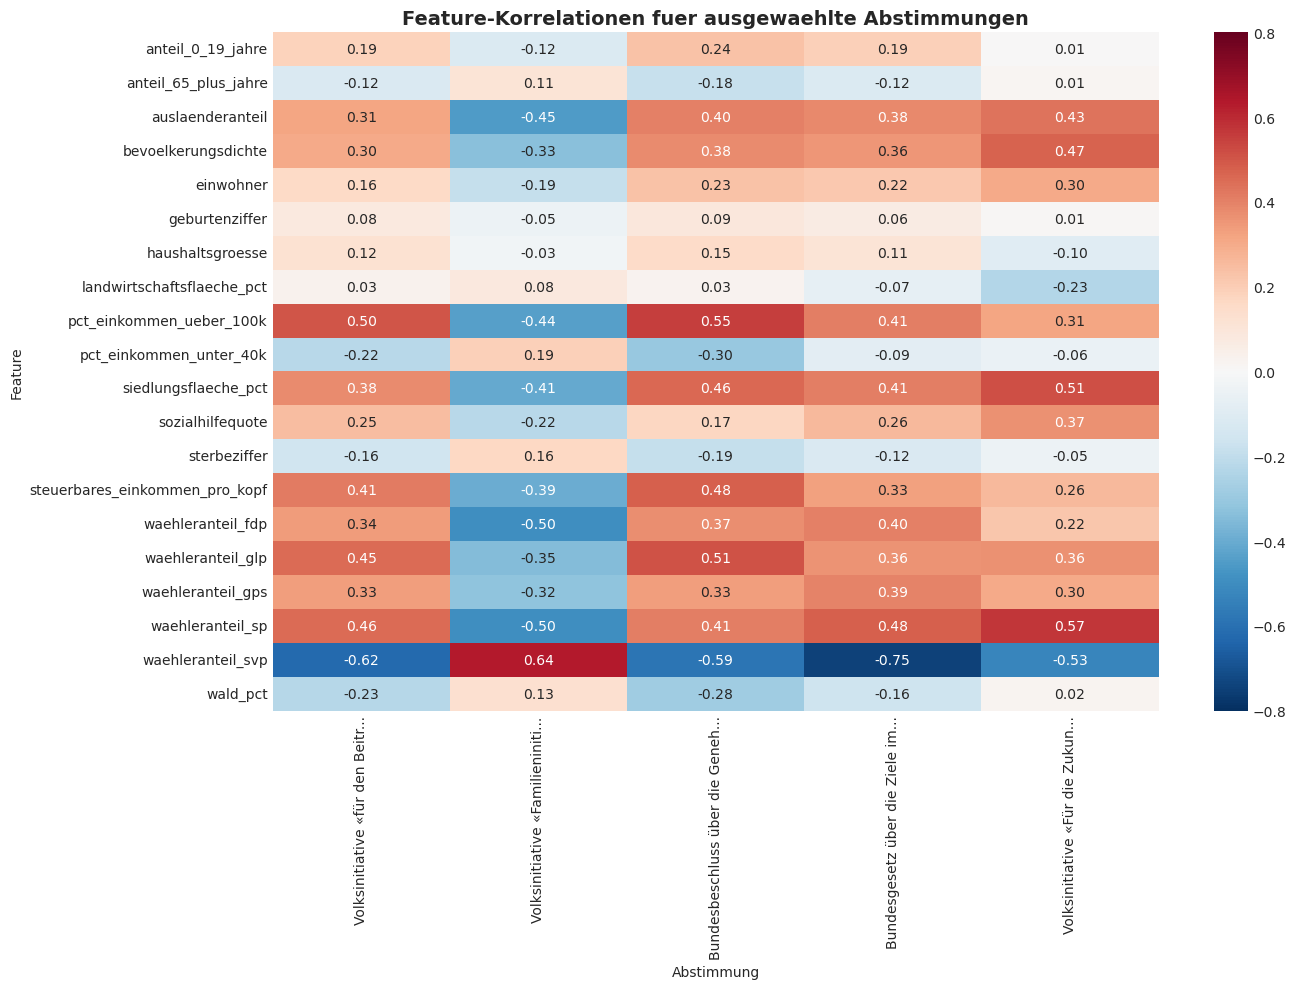

In [8]:
# Create heatmap for selected proposals
fig, ax = plt.subplots(figsize=(14, 10))

# Pivot table for heatmap
df_pivot = df_corr[df_corr['proposal_id'].isin(top_5_proposals)].pivot_table(
    index='feature',
    columns='proposal_id',
    values='correlation'
)

# Get short titles for columns
title_map = df_corr[df_corr['proposal_id'].isin(top_5_proposals)].drop_duplicates('proposal_id').set_index('proposal_id')['title_de']
title_map = title_map.apply(lambda x: x[:30] + '...' if len(x) > 30 else x)
df_pivot.columns = [title_map[c] for c in df_pivot.columns]

sns.heatmap(df_pivot, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-0.8, vmax=0.8, ax=ax)
ax.set_title('Feature-Korrelationen fuer ausgewaehlte Abstimmungen', fontsize=14, fontweight='bold')
ax.set_xlabel('Abstimmung')
ax.set_ylabel('Feature')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'correlation_features_vs_votes_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Feature-Ranking ueber alle Abstimmungen

In [9]:
# Which features have the highest average correlation across all proposals?
feature_importance = df_corr.groupby('feature').agg(
    mean_abs_corr=('abs_correlation', 'mean'),
    max_abs_corr=('abs_correlation', 'max'),
    n_strong=('abs_correlation', lambda x: (x > 0.3).sum()),
    pct_significant=('significant', 'mean')
).sort_values('mean_abs_corr', ascending=False)

print("Feature-Ranking (sortiert nach mittlerer Korrelationsstaerke):")
feature_importance

Feature-Ranking (sortiert nach mittlerer Korrelationsstaerke):


,mean_abs_corr,max_abs_corr,n_strong,pct_significant
feature,,,,
waehleranteil_svp,0.413254,0.764694,151,0.955157
waehleranteil_sp,0.334012,0.631367,136,0.928251
waehleranteil_gps,0.291130,0.589044,122,0.825112
pct_einkommen_ueber_100k,0.250595,0.591136,85,0.869955
waehleranteil_fdp,0.237188,0.542719,77,0.865471
steuerbares_einkommen_pro_kopf,0.229922,0.596279,79,0.834081
waehleranteil_glp,0.226389,0.545927,73,0.798206
sozialhilfequote,0.212600,0.547221,48,0.829596
auslaenderanteil,0.189627,0.451393,33,0.847534


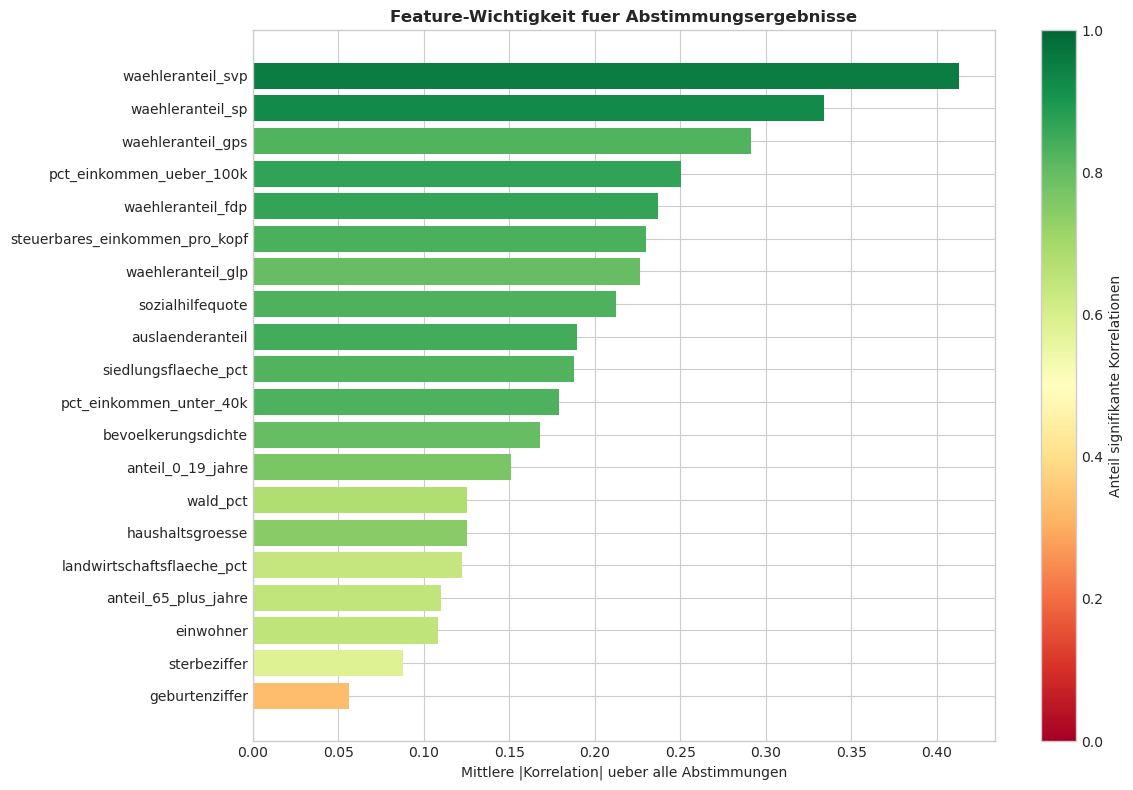

In [10]:
# Bar plot of feature importance
fig, ax = plt.subplots(figsize=(12, 8))

feature_importance_sorted = feature_importance.sort_values('mean_abs_corr', ascending=True)
colors = plt.cm.RdYlGn(feature_importance_sorted['pct_significant'])

bars = ax.barh(range(len(feature_importance_sorted)), 
               feature_importance_sorted['mean_abs_corr'],
               color=colors)

ax.set_yticks(range(len(feature_importance_sorted)))
ax.set_yticklabels(feature_importance_sorted.index)
ax.set_xlabel('Mittlere |Korrelation| ueber alle Abstimmungen')
ax.set_title('Feature-Wichtigkeit fuer Abstimmungsergebnisse', fontweight='bold')

# Add colorbar for significance
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(0, 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Anteil signifikante Korrelationen')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_importance_voting.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Export fuer MLR

In [11]:
# Save selected proposals and their features for MLR
mlr_config = []

for pid in top_5_proposals:
    df_p = df_corr[df_corr['proposal_id'] == pid].sort_values('abs_correlation', ascending=False)
    
    # Select top features with |r| > 0.2 (up to 10)
    top_features = df_p[df_p['abs_correlation'] > 0.2].head(10)['feature'].tolist()
    
    # Ensure at least 5 features
    if len(top_features) < 5:
        top_features = df_p.head(5)['feature'].tolist()
    
    mlr_config.append({
        'proposal_id': pid,
        'title_de': df_p['title_de'].iloc[0],
        'voting_date': df_p['voting_date'].iloc[0],
        'features': top_features,
        'n_features': len(top_features)
    })

df_mlr_config = pd.DataFrame(mlr_config)

print("\n" + "="*70)
print("KONFIGURATION FUER MULTIPLE LINEARE REGRESSION")
print("="*70)
for _, row in df_mlr_config.iterrows():
    print(f"\n{row['voting_date']} - {row['title_de'][:50]}")
    print(f"  Features ({row['n_features']}):")
    for f in row['features']:
        print(f"    - {f}")

# Save configuration
df_mlr_config.to_json(OUTPUT_DIR / 'mlr_config.json', orient='records', indent=2)
print("\nGespeichert: mlr_config.json")


KONFIGURATION FUER MULTIPLE LINEARE REGRESSION

20190519 - Bundesbeschluss über die Genehmigung und die Umset
  Features (10):
    - waehleranteil_svp
    - pct_einkommen_ueber_100k
    - waehleranteil_glp
    - steuerbares_einkommen_pro_kopf
    - siedlungsflaeche_pct
    - waehleranteil_sp
    - auslaenderanteil
    - bevoelkerungsdichte
    - waehleranteil_fdp
    - waehleranteil_gps

20020303 - Volksinitiative «für den Beitritt der Schweiz zur 
  Features (10):
    - waehleranteil_svp
    - pct_einkommen_ueber_100k
    - waehleranteil_sp
    - waehleranteil_glp
    - steuerbares_einkommen_pro_kopf
    - siedlungsflaeche_pct
    - waehleranteil_fdp
    - waehleranteil_gps
    - auslaenderanteil
    - bevoelkerungsdichte

20131124 - Volksinitiative «Familieninitiative: Steuerabzüge 
  Features (10):
    - waehleranteil_svp
    - waehleranteil_fdp
    - waehleranteil_sp
    - auslaenderanteil
    - pct_einkommen_ueber_100k
    - siedlungsflaeche_pct
    - steuerbares_einkommen_pro_ko

In [12]:
# Save full correlation results
df_corr.to_csv(OUTPUT_DIR / 'features_voting_correlations.csv', index=False)
print("Gespeichert: features_voting_correlations.csv")

# Summary stats
print("\n" + "="*70)
print("ZUSAMMENFASSUNG")
print("="*70)
print(f"Analysierte Abstimmungen: {df_corr['proposal_id'].nunique()}")
print(f"Analysierte Features: {df_corr['feature'].nunique()}")
print(f"Berechnete Korrelationen: {len(df_corr)}")
print(f"\nStaerkste Features (hoeachste mittlere |r|):")
print(feature_importance.head(5).to_string())
print(f"\nAusgewaehlte 5 Abstimmungen fuer MLR:")
for _, row in df_mlr_config.iterrows():
    print(f"  - {row['title_de'][:60]}")
print("="*70)

conn.close()

Gespeichert: features_voting_correlations.csv

ZUSAMMENFASSUNG
Analysierte Abstimmungen: 223
Analysierte Features: 20
Berechnete Korrelationen: 4460

Staerkste Features (hoeachste mittlere |r|):
                          mean_abs_corr  max_abs_corr  n_strong  pct_significant
feature                                                                         
waehleranteil_svp              0.413254      0.764694       151         0.955157
waehleranteil_sp               0.334012      0.631367       136         0.928251
waehleranteil_gps              0.291130      0.589044       122         0.825112
pct_einkommen_ueber_100k       0.250595      0.591136        85         0.869955
waehleranteil_fdp              0.237188      0.542719        77         0.865471

Ausgewaehlte 5 Abstimmungen fuer MLR:
  - Bundesbeschluss über die Genehmigung und die Umsetzung des N
  - Volksinitiative «für den Beitritt der Schweiz zur Organisati
  - Volksinitiative «Familieninitiative: Steuerabzüge auch für E
  - 